# RNN・LSTM(PyTorch)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set()

np.random.seed(1)
torch.manual_seed(1)

## データ生成

In [2]:
# sin曲線+ノイズ
ts = np.linspace(0, 10 * np.pi, 500)
ys = np.sin(ts) + np.random.normal(scale=0.1, size=len(ts))

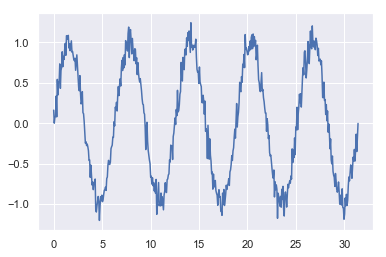

In [3]:
plt.plot(ts, ys)

In [4]:
# 学習設定
batch_size = 32    # ミニバッチサイズ
n_steps = 50       # 入力系列の長さ
input_size = 1     # 入力の次元
hidden_size = 50   #  中間層の次元
output_size = 1    # 出力層の次元

lr = 0.005         # 学習率(SGD)
n_iter = 500       # イテレーション回数

In [5]:
# 訓練データとテストデータに分割
train_ratio = 0.8
data = []
for i in range(len(ys) - n_steps - 1):
    data.append(ys[i: i+n_steps+1])
data = np.array(data, dtype=np.float32)
n_train = int(train_ratio * len(data))
x_train, y_train = np.split(data[:n_train], [-1], axis=1)
x_test, y_test = np.split(data[n_train:], [-1], axis=1)

x_train = np.reshape(x_train, [-1, n_steps, input_size])
x_test = np.reshape(x_test, [-1, n_steps, input_size])

## モデル構築

In [6]:
import torch.nn as nn


class RNN_Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_Net, self).__init__()
        
        # batch_first=True; then
        # input: (batch_size, n_steps, input_size)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) 
#         self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.l = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h_0=None):
        output, h_n = self.rnn(x, h_0)
        return self.l(output[:, -1])

In [7]:
# モデルをインスタンス化
model = RNN_Net(input_size, hidden_size, output_size)
# 最適化手法を設定
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters())
# 損失関数を設定
loss_fun = nn.MSELoss()

## 学習

In [8]:
# 訓練データのインデックスをランダムに
perm = np.random.permutation(len(x_train))

for i in range(n_iter):
    idx = (i * batch_size) % len(x_train)
    batch_x, batch_y = x_train[perm[idx: idx+batch_size]], y_train[perm[idx: idx+batch_size]]
    batch_x, batch_y = torch.tensor(batch_x), torch.tensor(batch_y)    
    
    y = model(batch_x)
    loss = loss_fun(y, batch_y)
    
    # パラメータ更新（勾配のリセット+誤差逆伝播+更新）
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 50 == 0:
        print("step: {}, loss {:.5f}".format(i, loss.data))

step: 0, loss 0.47035
step: 50, loss 0.02616
step: 100, loss 0.01672
step: 150, loss 0.01208
step: 200, loss 0.01284
step: 250, loss 0.01859
step: 300, loss 0.01547
step: 350, loss 0.01088
step: 400, loss 0.00990
step: 450, loss 0.01657


## テスト

In [9]:
# テストデータに対する予測
x_test = torch.tensor(x_test)
prediction = model(x_test)

# 1次元配列に
prediction = prediction.detach().numpy().reshape(-1)
true_y = y_test.reshape(-1)

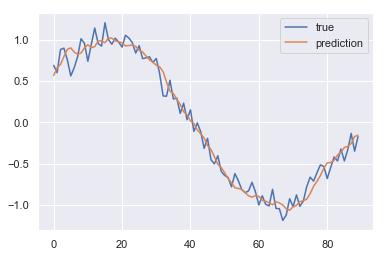

In [10]:
# テストデータに対する予測を可視化
xx = np.arange(len(prediction))
plt.plot(xx, true_y, label='true')
plt.plot(xx, prediction, label='prediction')
plt.legend()

## 再帰的な予測

In [11]:
# テストデータの最初のデータからスタートし、
# モデルの予測を利用し再帰的に予測
curr_x = x_test[0]
predicted = []
# 予測するステップ数
N = 200
for i in range(N):
    # 予測
    pred = model(curr_x[None])
    predicted.append(pred.item())
    # 入力を更新
    curr_x = torch.cat([curr_x[1:], pred], dim=0)

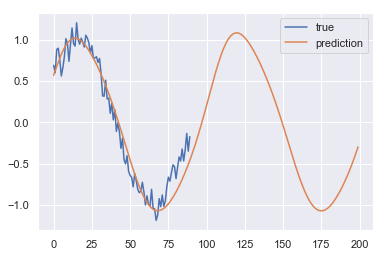

In [12]:
#再帰的な予測を可視化
plt.plot(xx, true_y, label='true')
plt.plot(np.arange(N), predicted, label='prediction')
plt.legend()